In [1]:
import torch
import matplotlib.pyplot as plt
from torch.optim import SGD

In [2]:
class Model(torch.nn.Module):
    def __init__(self,):
        super(Model, self).__init__()
        self.model = torch.nn.Conv2d(1, 2, 3)
    def forward(self, x):
        return self.model(x)

In [3]:
model = Model()
params = model.parameters()

### Cosine Annealing Scheduler

In [4]:
from torch.optim.lr_scheduler import CosineAnnealingLR


In [5]:
nepoch = 10
ldloader = 100
nsteps = nepoch * ldloader
optimizer = SGD(params, lr=0.001)
schduler = CosineAnnealingLR(optimizer, 2*ldloader, 1e-4)

In [6]:
lr = []
for e in range(nepoch):
    for b in range(ldloader):
        schduler.step()
        lr.extend(schduler.get_last_lr())

/home/adnen/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


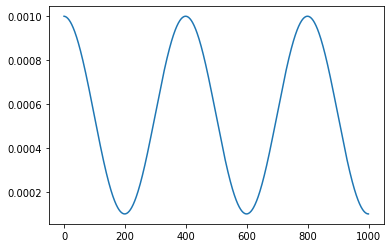

In [7]:
plt.plot(lr)

#### ReduceOnPlateau

In [8]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = Model()
params = model.parameters()
nepoch = 10
ldloader = 100
nsteps = nepoch * ldloader
optimizer = SGD(params, lr=0.001)
scheduler = ReduceLROnPlateau(optimizer,
                              mode='min',
                              factor=0.5,
                              patience=50,
                              verbose=True,
                              threshold=0.01,
                              threshold_mode='rel',
                              cooldown=0,
                              min_lr=1e-4,
                              eps=1e-08)


In [9]:
lr = []
losses = []
for e in range(nepoch):
    for b in range(ldloader):
        loss = 10 - int(e/nepoch*5)
        scheduler.step(loss)
        lr.extend(scheduler._last_lr)

Epoch    52: reducing learning rate of group 0 to 5.0000e-04.
Epoch   103: reducing learning rate of group 0 to 2.5000e-04.
Epoch   154: reducing learning rate of group 0 to 1.2500e-04.
Epoch   252: reducing learning rate of group 0 to 1.0000e-04.


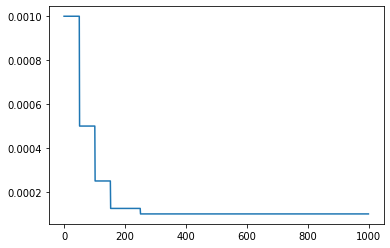

In [10]:
import numpy as np
plt.plot(np.arange(nepoch*ldloader), lr)

#### CosineAnnealingWithWarmUpStart

In [27]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

model = Model()
params = model.parameters()
nepoch = 4
ldloader = 169
nsteps = nepoch * ldloader
optimizer = SGD(params, lr=0.001)

scheduler = CosineAnnealingWarmRestarts(optimizer,
                            T_0=170,
                            T_mult=2,
                            eta_min=1e-7, 
                            last_epoch=-1,
                                           )

In [28]:
lr = []
losses = []
for e in range(nepoch):
    for b in range(ldloader):
        scheduler.step()
        lr.extend(scheduler.get_last_lr())

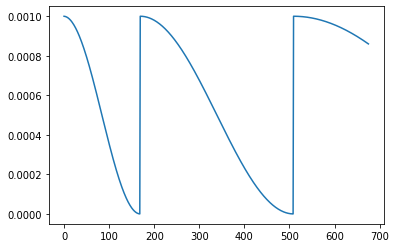

In [29]:
plt.plot(lr)

In [14]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [15]:
model = Model()
params = model.parameters()
nepoch = 15
ldloader = 169
nsteps = nepoch * ldloader
optimizer = SGD(params, lr=0.00001)
scheduler = CosineAnnealingWarmUpRestarts(optimizer,
                            T_0=180,
                            T_mult=2,
                            eta_max=1e-3, 
                            last_epoch=-1,
                            T_up=10,
                            gamma=.8)

In [16]:
lr = []
losses = []
for e in range(nepoch):
    for b in range(ldloader):
        scheduler.step()
        lr.extend(scheduler.get_lr())

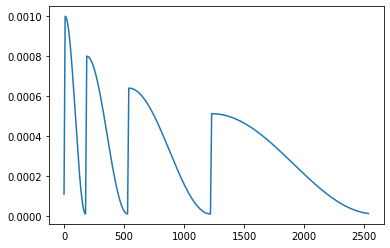

In [17]:
plt.plot(lr)